Found 1097 files belonging to 3 classes.
Using 878 files for training.
Found 1097 files belonging to 3 classes.
Using 219 files for validation.
 Clase: ['Bengin cases', 'Malignant cases', 'Normal cases']
 Class Weights: {0: 2.9562289562289563, 1: 0.644640234948605, 2: 0.9005128205128206}
 Training CNN simplu...
Epoch 1/40
28/28 [==============================] - 9s 164ms/step - loss: 1.3864 - accuracy: 0.3952 - val_loss: 1.0435 - val_accuracy: 0.4840
Epoch 2/40
28/28 [==============================] - 6s 225ms/step - loss: 1.0961 - accuracy: 0.4533 - val_loss: 1.0551 - val_accuracy: 0.5936
Epoch 3/40
28/28 [==============================] - 6s 229ms/step - loss: 1.0751 - accuracy: 0.3952 - val_loss: 1.0960 - val_accuracy: 0.2557
Epoch 4/40
28/28 [==============================] - 7s 234ms/step - loss: 1.0593 - accuracy: 0.4157 - val_loss: 1.0460 - val_accuracy: 0.3059
Epoch 5/40
28/28 [==============================] - 7s 232ms/step - loss: 1.0088 - accuracy: 0.4704 - val_loss: 1.0048 

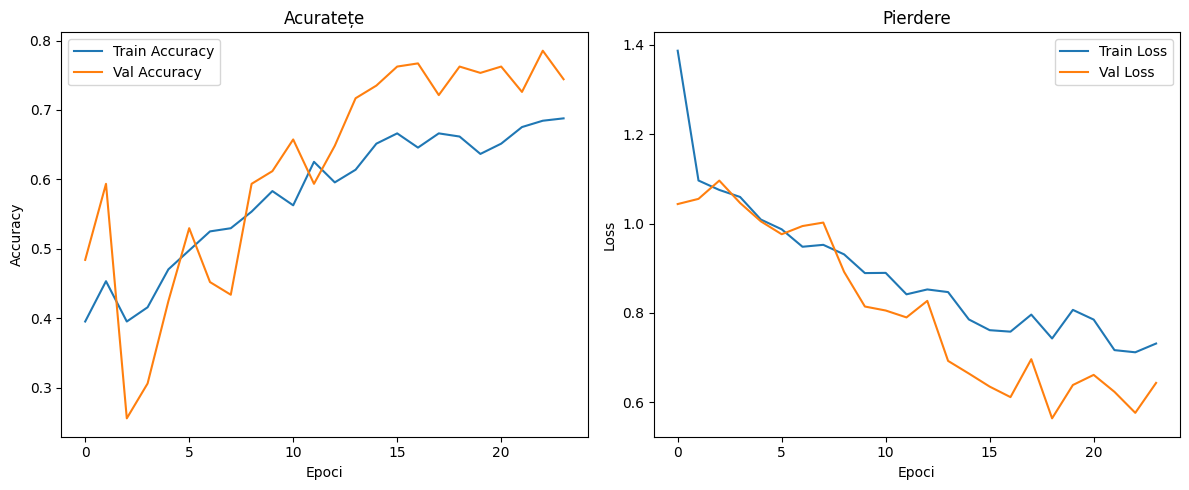

 Evaluare finală pe setul de validare...
1/1 [==============================] - 0s 42ms/step

 Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       0.42      0.67      0.52        21
Malignant cases       0.81      0.89      0.84       107
   Normal cases       0.85      0.64      0.73        91

       accuracy                           0.76       219
      macro avg       0.69      0.73      0.70       219
   weighted avg       0.79      0.76      0.77       219



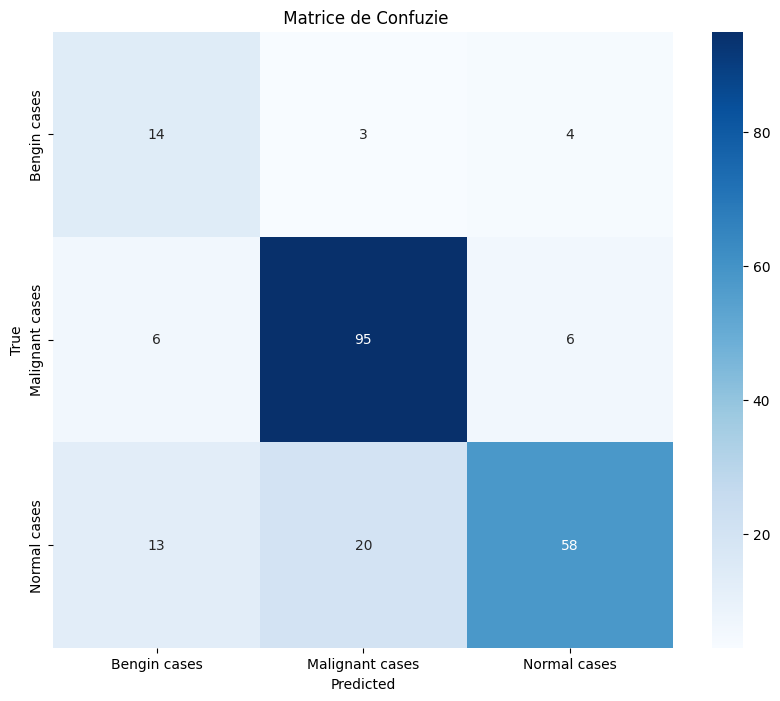

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ---------------------------
# 1. Setari
# ---------------------------
DATASET_PATH = r"C:\Users\Luchi\Desktop\LicentaCompleta\Imagini\TrainImages"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 40
AUTOTUNE = tf.data.AUTOTUNE

# ---------------------------
# 2. Incarcarea datelor
# ---------------------------
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds_raw.class_names
num_classes = len(class_names)
print(" Clase:", class_names)

# ---------------------------
# 3. Augmentare + pipeline
# ---------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds_raw.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(AUTOTUNE)
val_ds = val_ds_raw.prefetch(AUTOTUNE)

# ---------------------------
# 4. Class Weights
# ---------------------------
y_labels = []
for _, labels in train_ds_raw:
    y_labels.extend(labels.numpy())

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_labels),
    y=y_labels
)
class_weights_dict = dict(enumerate(class_weights))
print(" Class Weights:", class_weights_dict)

# ---------------------------
# 5. Model CNN simplu
# ---------------------------
def build_simple_cnn(input_shape, num_classes):
    return models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

simple_cnn = build_simple_cnn((*IMG_SIZE, 3), num_classes)
simple_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ---------------------------
# 6. Callbacks
# ---------------------------
early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

# ---------------------------
# 7. Antrenare model
# ---------------------------
print(" Training CNN simplu...")
history = simple_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

try:
    simple_cnn.save("simple_model.keras", save_format="keras")
    print(" Model salvat cu succes în formatul Keras.")
except TypeError as e:
    print(" Eroare la salvare completă:", e)
    print(" Salvăm separat arhitectura și greutățile (fallback).")

    #  Salvare fallback (arhitectură + greutăți)
    model_json = simple_cnn.to_json()
    with open("simple_model_architecture.json", "w") as json_file:
        json_file.write(model_json)

    simple_cnn.save_weights("simple_model_weights.h5")
    print(" Arhitectură și greutăți salvate separat.")

# ---------------------------
# 8. Plotare rezultate
# ---------------------------
def plot_history(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Acuratețe')
    plt.xlabel('Epoci')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Pierdere')
    plt.xlabel('Epoci')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# ---------------------------
# 9. Evaluare pe setul de validare
# ---------------------------
print(" Evaluare finală pe setul de validare...")
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = simple_cnn.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ---------------------------
# 10. Matrice de confuzie
# ---------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(' Matrice de Confuzie')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_for_gradcam(img_path):
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized)  # NU face /255 aici, modelul are layers.Rescaling
    return img_array, img

def get_last_conv_layer_name(model):
    # Găsește ultimul strat Conv2D în model
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("Nu s-a găsit niciun strat Conv2D în model")

def display_gradcam(img_path, model, label_map, last_conv_layer_name=None):
    if last_conv_layer_name is None:
        last_conv_layer_name = get_last_conv_layer_name(model)
    print(f"Using last conv layer: {last_conv_layer_name}")

    img_array, original_img = preprocess_for_gradcam(img_path)
    
    # Pregătim tensorul cu batch size 1 și cu scalarea automat în model
    input_tensor = tf.expand_dims(img_array, axis=0)  # shape (1,224,224,3)
    
    # Modelul are un strat Rescaling, deci nu trebuie să preprocessăm aici
    
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_tensor)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]  # elimina batch dim

    # Multiplicăm fiecare canal de feature map cu importanța sa (pooled_grads)
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # ReLU
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()

    # Redimensionăm heatmap la dimensiunea imaginii originale
    heatmap = cv2.resize(heatmap, (224, 224))

    # Convertim heatmap la culori (Jet)
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Imaginea originală redimensionată (pentru suprapunere)
    original_resized = np.array(original_img.resize((224, 224)).convert("RGB"))

    # Suprapunere heatmap peste imagine
    superimposed_img = cv2.addWeighted(original_resized, 0.6, heatmap_color, 0.4, 0)

    # Predicție
    preds = model.predict(np.expand_dims(img_array, axis=0))[0]
    pred_class = label_map[np.argmax(preds)]
    pred_confidence = np.max(preds)

    print(f"Predicție: {pred_class} ({pred_confidence:.2f})")

    # Plotare
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Imagine originală")
    plt.axis("off")
    plt.imshow(original_resized)

    plt.subplot(1,2,2)
    plt.title(f"Grad-CAM: {pred_class} ({pred_confidence:.2f})")
    plt.axis("off")
    plt.imshow(superimposed_img)
    plt.show()

# Exemplu de folosire:

label_map = train_ds_raw.class_names  # asigură-te că e ordinea corectă a claselor
last_conv_layer = "max_pooling2d_9"

# Pune calea către imaginea ta de test:
img_path = r"C:\Users\Luchi\Desktop\archive\test1.jpg"

display_gradcam(img_path, simple_cnn, label_map, last_conv_layer)
